# SITCOM-797

Here is what was requested:

To analyze the positioning system after a slew, create plots for the mirror

decentering (X and Y)
mirror tilt (RX, RY, RY)
piston
Create a histogram for each parameter for a configurable time period.

Include the limits in all plots:

the mirror decenters at less than +/- 6 micrometer
mirror tilt less than +/- 24 e-6 degree
piston less than +/- 1 micrometer


### Prepare Notebook

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3
from lsst_efd_client import EfdClient

In [4]:
client = EfdClient('usdf_efd')

### Define functions

In [11]:
def compareIMSMount(df_ims,
                   df_mtmount_ele,
                   df_mtmount_azi,
                   slew_stop = '2023-06-01 06:53:37.326',
                   lo_delta_t = 5, #in seconds
                   hi_delta_t = 30, #in seconds
                   correct_tai = False): 
    
    tai_delta = 0
    if correct_tai:
        tai_delta = 37
    
    fig,axs = plt.subplots(5,1, dpi=125, figsize=(6,8))
    t_start_plot = pd.to_datetime(slew_stop) \
        + pd.to_timedelta(tai_delta,unit='s') - pd.to_timedelta(lo_delta_t,unit='s') ##correcting by hand for TAI, is this correct?
    t_end_plot = pd.to_datetime(slew_stop) \
        + pd.to_timedelta(tai_delta,unit='s') + pd.to_timedelta(hi_delta_t,unit='s')
    #selected_time = (mtmount_ele_times > t_start_plot) & (mtmount_times < t_end_plot)

    ax = axs[0]
    actpos_ele = df_mtmount_ele['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_ele,color='red', lw="0.5")
    ax.axvline(pd.to_datetime(slew_stop)+ pd.to_timedelta(37,unit='s'), lw="0.5", c="k")
    ax.set_ylabel("Elevation Position\n[deg]")

    ax = axs[1]
    actpos_azi = df_mtmount_azi['actualPosition'][t_start_plot:t_end_plot]
    ax.plot(actpos_azi,color='red', lw="0.5")
    ax.set_ylabel("Azimuth Position\n[deg]")

    t_start_plot = pd.to_datetime(slew_stop) - pd.to_timedelta(lo_delta_t,unit='s') 
    t_end_plot = pd.to_datetime(slew_stop) + pd.to_timedelta(hi_delta_t,unit='s')
    
    plotstring = ['xPosition','yPosition','zPosition']
    plotrange = np.arange(len(plotstring))    
    for i in plotrange:
        ax = axs[i+2]
        pos = df_ims[plotstring[i]][t_start_plot:t_end_plot]
        ax.plot(pos,color='red', lw="0.5")
        ax.set_ylabel(plotstring[i] + ' in mm')
    ax.set_xlabel('UTC')
    fig.autofmt_xdate()

### Query Data

In [5]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]
print(pos_columns, rot_columns)

['xPosition', 'yPosition', 'zPosition'] ['xRotation', 'yRotation', 'zRotation']


In [6]:
#define the date
t_start = Time('2023-06-01 06:00:0Z', scale='utc')
t_end = Time('2023-06-01 10:00:0Z', scale='utc') 
#t_start = Time('2023-05-30 04:35:0Z', scale='utc')
#t_end = Time('2023-05-30 05:30:0Z', scale='utc') 

### Load data

In [7]:
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_ims = df_ims.set_index("private_sndStamp") #time when data was sent to EFD, in TAI
df_ims.index = pd.to_datetime(df_ims.index, unit="s")
df_ims = df_ims[all_columns]

df_ims[pos_columns] = df_ims[pos_columns] * 1e3 #to mm
df_ims[rot_columns] = np.rad2deg(df_ims[rot_columns]) #to degrees

In [8]:
df_mtmount_ele = await client.select_time_series(
    "lsst.sal.MTMount.elevation",
    ["*"],  
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
df_mtmount_ele = df_mtmount_ele.set_index("private_sndStamp") #time when data was sent to EFD, in TAI
df_mtmount_ele.index = pd.to_datetime(df_mtmount_ele.index, unit="s")

df_mtmount_azi = await client.select_time_series(
    "lsst.sal.MTMount.azimuth",
    ["*"],  
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
df_mtmount_azi = df_mtmount_azi.set_index("private_sndStamp")
df_mtmount_azi.index = pd.to_datetime(df_mtmount_azi.index, unit="s")


### Get slew stops

In [9]:
# the following are a set of slew stops identified by Peter Ferguson

stops_v1 = ['2023-06-01 06:45:39.978','2023-06-01 06:53:37.326',
         '2023-06-01 07:22:22.723','2023-06-01 07:36:40.422',
         '2023-06-01 07:50:58.814','2023-06-01 08:05:17.119',
         '2023-06-01 08:19:03.799','2023-06-01 08:34:19.955',
         '2023-06-01 08:47:56.442','2023-06-01 09:01:33.275']

el_stops = ['2023-06-01 06:53:36.498', '2023-06-01 07:08:10.938',
 '2023-06-01 07:22:21.885', '2023-06-01 07:22:29.878',
 '2023-06-01 07:36:39.694', '2023-06-01 07:36:47.851',
 '2023-06-01 07:50:57.911', '2023-06-01 07:51:06.064',
 '2023-06-01 08:05:16.210', '2023-06-01 08:19:03.025',
 '2023-06-01 08:20:50.933', '2023-06-01 08:34:19.055',
 '2023-06-01 08:34:26.978', '2023-06-01 08:47:55.580',
 '2023-06-01 08:48:03.409', '2023-06-01 09:01:32.391',
 '2023-06-01 09:01:40.310', '2023-05-30 05:00:00'] #elevation stops

az_stops =  ['2023-06-01 07:08:02.386', '2023-06-01 07:18:32.843',
 '2023-06-01 07:22:29.569', '2023-06-01 07:32:50.835',
 '2023-06-01 07:36:47.452', '2023-06-01 07:47:08.111',
 '2023-06-01 07:51:05.588', '2023-06-01 08:01:25.757',
 '2023-06-01 08:20:43.167', '2023-06-01 08:31:21.849',
 '2023-06-01 08:34:26.969', '2023-06-01 08:44:46.324', 
 '2023-06-01 08:48:03.139', '2023-06-01 08:58:14.787'] #azimuth stops

stable = ['2023-05-30 05:00:00']


### Look at data

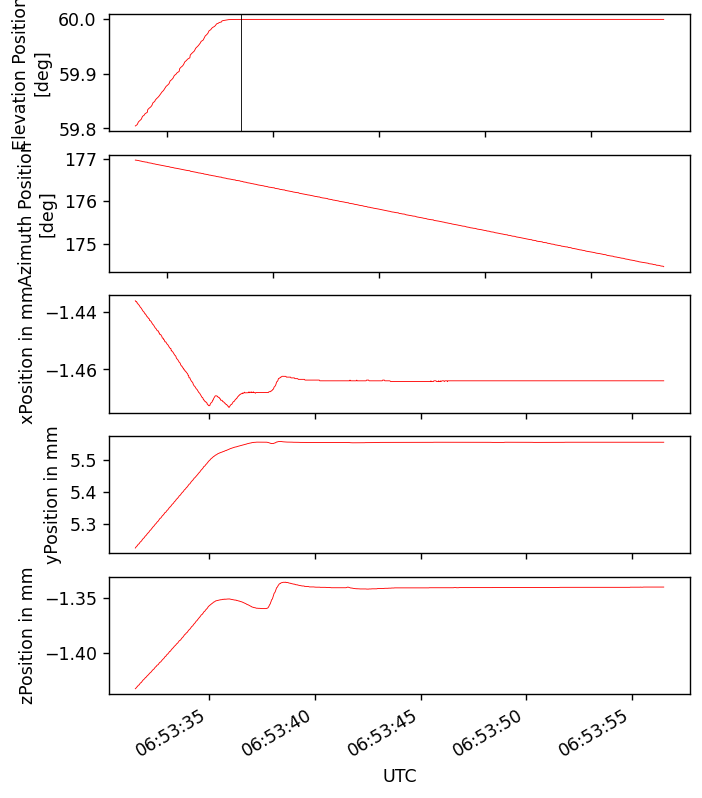

In [13]:
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,el_stops[0],5,20,correct_tai=True)

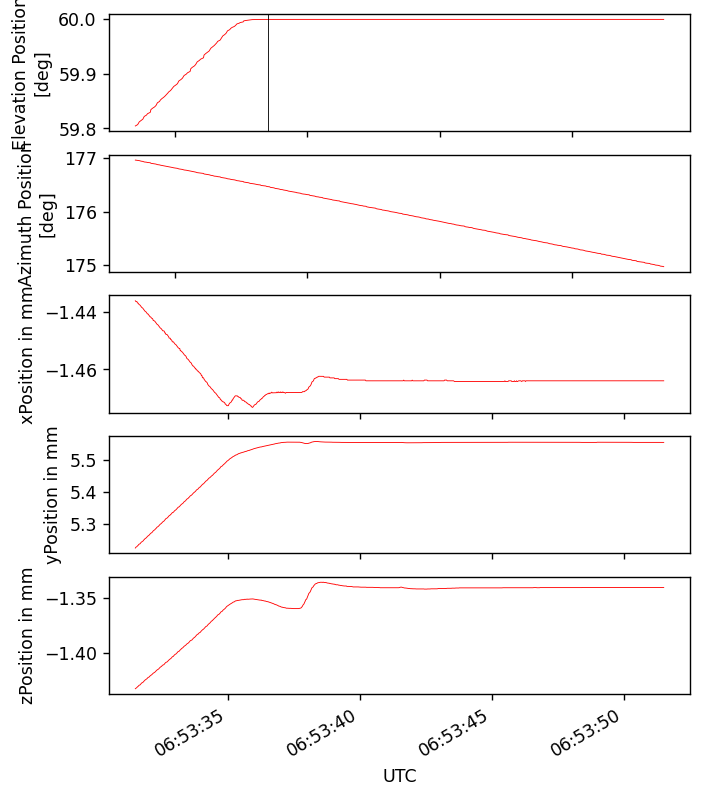

In [16]:
compareIMSMount(df_ims,df_mtmount_ele,df_mtmount_azi,el_stops[0],5,15,correct_tai=True)